In [1]:
import itertools
from functools import partial

import numpy as np
from tqdm import tqdm

import jax
jax.config.update("jax_default_matmul_precision", "highest")
jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp
from jax_tqdm import scan_tqdm

from special_unitary import (
    fast_expi_su3,
    special_unitary_grad,
    unitary_violation,
    proj_SU3
)

from integrators import int_2MN, int_4MN4FP
from gauge_field_utils import (
    wilson_action,
    wilson_gauge_error,
    luscher_weisz_action,
    luscher_weisz_gauge_error,
    wilson_loops_range,
    smear_HYP,
    smear_stout,
    mean_plaquette
)

%matplotlib inline
import matplotlib.pyplot as plt

In [57]:
configs = jnp.load("../results/configs_3-25-25_5/configs_3-25-25_5.npz")

wilson_loops = []

for config in tqdm(configs.values()):
    config = smear_HYP(config, 0.75, 0.6, 0.3)
    wilson_loops.append(np.array(wilson_loops_range(config, R=10, T=10)))

wilson_loops = np.stack(wilson_loops)

100%|██████████| 456/456 [04:33<00:00,  1.67it/s]


In [58]:
@partial(jax.jit, static_argnums=(1,))
def jackknife_stats(data, statistic):
    N = len(data)

    jack_estimates = jax.vmap(lambda x, i: statistic(jnp.delete(x, i, axis=0, assume_unique_indices=True)), in_axes=[None, 0])(data, jnp.arange(N))

    estimate = jnp.mean(jack_estimates, axis=0)
    bias = (N - 1) * (estimate - statistic(data))
    stderr = jnp.sqrt((N - 1) * jnp.var(jack_estimates, axis=0, ddof=1))

    return estimate, bias, stderr

In [59]:
mean_wilson_loops, _, err_wilson_loops = jackknife_stats(wilson_loops.real, lambda x: jnp.mean(x, axis=0))

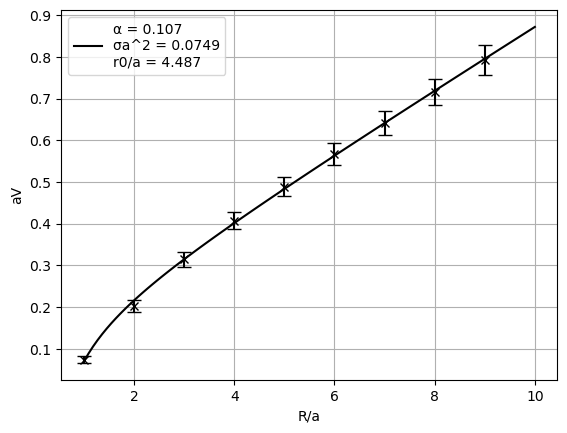

In [66]:
from jax.scipy.optimize import minimize

@jax.jit
def effective_potential(W1, W2, dW1, dW2):
    energy_fn = lambda x: jnp.log(x[0] / x[1])
    stderr_fn = lambda x, dx: jnp.sqrt(jnp.square(jax.grad(energy_fn)(x) * dx).sum())

    X = jnp.stack([W1, W2], axis=1)
    dX = jnp.stack([dW1, dW2], axis=1)

    V = jax.vmap(energy_fn, in_axes=(0,))(X)
    dV = jax.vmap(stderr_fn, in_axes=(0, 0))(X, dX)

    return V, dV

R_range = (0, -1)
T_level = 4

V, dV = effective_potential(mean_wilson_loops[R_range[0]:R_range[1], T_level], mean_wilson_loops[R_range[0]:R_range[1], T_level+1],
                    err_wilson_loops[R_range[0]:R_range[1], T_level], err_wilson_loops[R_range[0]:R_range[1], T_level+1])
R = (jnp.arange(len(V))+1+R_range[0]).astype(V.dtype)

V0_latt, alpha_latt, sigma_latt = minimize(lambda x: jnp.square(x[0] - 4*x[1]/(3*R) + x[2]*R - V).mean(), x0=jnp.array([0.1, 0.1, 0.1]), method="BFGS").x

R_cont = np.linspace(1, len(mean_wilson_loops), 100)
V_fit = V0_latt - 4*alpha_latt/(3*R_cont) + sigma_latt*R_cont

sommer_r0 = jnp.sqrt((1.65 - 4*alpha_latt/3) / sigma_latt)

plt.errorbar(R, V, dV, fmt='x', capsize=5, c="black")
plt.plot(R_cont, V_fit, label=f"α = {alpha_latt:.3g}\nσa^2 = {sigma_latt:.3g}\nr0/a = {sommer_r0:.4g}", c="black")

plt.xlabel("R/a")
plt.ylabel("aV")
plt.legend()
plt.grid()
plt.show()

#### Sommer parameter $r_0$ with error according to https://arxiv.org/pdf/hep-lat/0112024

In [67]:
from scipy.optimize import curve_fit

def fit_func(t, E1, E2, c1, c2):
    return c1*np.exp(-E1*t) + c2*np.exp(-E2*t)

V, Verr = np.stack([(lambda x: np.stack([x[0][(0, 1),], np.sqrt(x[1][(0, 1), (0, 1)])]))(curve_fit(fit_func, xdata=np.arange(2, 9+1), ydata=mean_wilson_loops[i, 1:9], p0=np.array([0.1,]*4), maxfev=50000)) for i in range(10)]).min(axis=(2,)).T
R = (np.arange(1, 10+1)).astype(V.dtype)

In [68]:
def smearing_factor_fn(p1, p2, p3, alpha1, alpha2, alpha3):
    psqr_omega = (p1**2)*(1 + alpha2*(1 + alpha3) - alpha2/4*(p2**2 + p3**2)) + alpha2*alpha3/4*(p1**2 * p2**2 * p3**2) \
            + (p2**2)*(1 + alpha2*(1 + alpha3) - alpha2/4*(p1**2 + p3**2)) + alpha2*alpha3/4*(p1**2 * p2**2 * p3**2) \
            + (p3**2)*(1 + alpha2*(1 + alpha3) - alpha2/4*(p1**2 + p2**2)) + alpha2*alpha3/4*(p1**2 * p2**2 * p3**2)
    
    factor = 1 - psqr_omega*alpha1/6

    return factor

def integrand_fn(*p):
    p1, p2, p3 = p
    
    alpha1 = 0.75
    alpha2 = 0.6
    alpha3 = 0.3
    
    ph1 = 2*np.sin(p1/2)
    ph2 = 2*np.sin(p2/2)
    ph3 = 2*np.sin(p3/2)

    factor = smearing_factor_fn(ph1, ph2, ph3, alpha1, alpha2, alpha3)
    
    integrand = np.cos(9*p1 + 0*p2 + 0*p3) * factor / (ph1**2 + ph2**2 + ph3**2)
    integrand /= (2*np.pi)**3

    return integrand

# from scipy.integrate import tplquad

# tplquad(
#     integrand_fn,
#     0,
#     np.pi,
#     0,
#     np.pi,
#     0,
#     np.pi,
# )

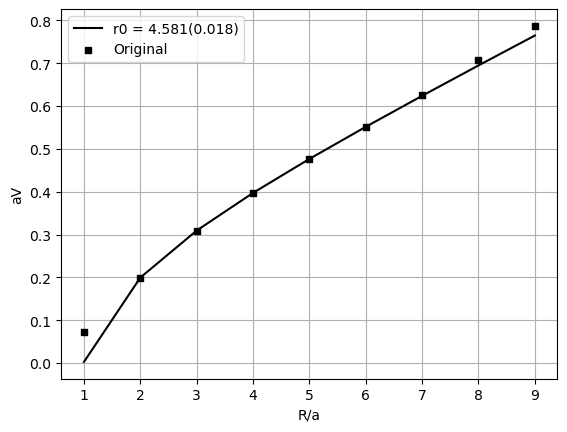

In [80]:
# v_pert = 2*np.array([0.009867431721938427, 0.00517789705788607, 0.003401324644674966, 0.002525119494884101, 0.0020092099028036743, 0.0016693153607904823, 0.0014282417484053874, 0.0012482353819993186, 0.001108642498800295])
# def static_potential_curve(r, c0, c1, c2, c3):
#     v_cont = c0/r + c1 + c2*r
#     delta_v_latt = c3 * (4*np.pi * v_pert[int(r[0]-1):int(r[-1])] - 1 / r)
#     return v_cont + delta_v_latt
def static_potential_curve(r, c0, c1, c2):
    v_cont = c0/r + c1 + c2*r
    return v_cont

(c0, c1, c2), perr = curve_fit(
    static_potential_curve,
    R[1:-4],
    V[1:-4],
    p0=np.random.rand(3)
)

r0 = np.sqrt((1.65 + c0) / c2)
r0_err = jnp.sqrt(jnp.sum(jnp.square(jax.grad(lambda c: jnp.sqrt((1.65 + c[0]) / c[1]))(jnp.array([c0, c2]))) * perr[(0, 2), (0, 2)]))

plt.plot(R[:-1], c0/R[:-1] + c1 + c2*R[:-1], c="black", label=f"r0 = {r0:.3f}({r0_err:.3f})")
plt.scatter(R[:-1], V[:-1], marker="s", c="black", s=15, label="Original")
# plt.scatter(R[:-1], V[:-1] - c3*(4*np.pi*v_pert - 1 / R[:-1]), marker="x", c="black", label="Corrected")

plt.ylabel("aV")
plt.xlabel("R/a")
plt.grid()
plt.gca().set_axisbelow(True)
plt.legend()
plt.show()